## SVM(Support Vector Machine)

서포트 벡터라는 개념은 한강의 위치를 찾는데 사용되는 개념으로 한강은 도시가 강북인지 강남인지를 구분하는 결정 경계선(decision boundary)이다. 서포트 벡터는 결정 경계선을 찾는데 사용되는 개념이고 벡터는 2차원 공간상에 나타나는 데이터 포인트를 의미한다. 
따라서, 서포트 벡터는 결정 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미한다.
***
서포트 벡터와 결정 경계 사이의 거리를 마진이라 하고 SVM의 목표는 마진을 최대로 하는 결정 경계를 찾는 것이다.  
SVM에서는 약간의 오류를 허용하기 위해 비용(C)이라는 변수를 사용한다. 비용이 낮을수록 마진을 최대한 높이고 학습 에러율은 증가하는 방향으로 결정 경계선을 만들고 비용이 높을수록 마진은 낮아지고 학습 에러율은 감소하는 방향으로 결정 경계선을 만든다. 
비용이 너무 낮으면 과소 적합의 위험이 있고 너무 높으면 과대 적합의 위험이 있으니 적절한 비용값을 찾는 과정이 상당히 중요하다.

In [20]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'NanumGothicCoding'
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

### 1. 데이터 가져오기

In [2]:
df = pd.read_csv('./data/basketball_stat.csv')
df

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5
...,...,...,...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,6.1,10.4,2.8,1.0,1.0
96,Dwyane Wade,SG,0.8,6.2,4.5,3.8,1.4,0.7
97,Dion Waiters,SG,1.8,4.3,3.3,4.3,0.9,0.4
98,Hassan Whiteside,C,0.0,7.0,14.1,0.7,0.7,2.1


### 2. 데이터 정제

분별력이 있는 3점 슛을 사용

In [3]:
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
df

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5
...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,10.4,1.0
96,Dwyane Wade,SG,0.8,4.5,0.7
97,Dion Waiters,SG,1.8,3.3,0.4
98,Hassan Whiteside,C,0.0,14.1,2.1


데이터를 학습 데이터와 테스트 데이터로 나눔

In [4]:
train, test = train_test_split(df, test_size=0.2)
print(train.shape[0])
print(test.shape[0])

80
20


### 3. 최적의 SVM 파라미터 찾기 

SVM에서 RBF 커널(가우시안 커널)을 사용하므로 마진의 너비를 조정하는 파라미터(C)와 결정 경계선의 '곡률'을 조정하는 파라미터(gamma)를 알아야 한다.  
사이킷런의 그리드 서치(grid search)를 개발자가 부여한 비용과 감마의 후보들을 모두 조합해 최적의 비용과 감마값을 알아낸다.

커널 트릭(kernel trick)  
저차원 벡터 공간의 데이터를 고차원 벡터 공간으로 옮겨줌으로써 결정 경계를 찾는 방법이다.  
저차원의 데이터를 고차원의 데이터로 옮겨주는 함수를 매핑 함수라 하고 매핑 함수를 가지고 많은 양의 데이터를 저차원에서 고차원으로 옮기기에는 계산량이 너무 많아서 현실적으로 사용하기 어렵다.
실제로 데이터를 고차원으로 보내지는 않지만 보낸 것과 동일한 효과를 줘서 빠른 속도로 결정 경계를 찾는 방법이 고안되었으며 이를 커널 트릭이라 부른다.

GridSearchCV() 함수 실행 결과에 fit() 함수를 실행하면 그리드 서치를 사용해서 자동으로 최적의 파라미터를 찾아준다.

In [5]:
# 사이킷런에서 제공하는 GridSearchCV() 함수를 사용해 최적의 비용과 감마값을 알아내는 함수
def svc_param_selection(x, y, nfolds) : 
    svm_parameters = [{'kernel':['rbf'],
                      'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                      'C': [0.01, 0.1, 1, 10, 100, 1000]}]
    clf = GridSearchCV(SVC(), svm_parameters, cv=nfolds)
    clf.fit(x, y.values.ravel())
    print(clf.best_score_)     # 최고 점수
    print(clf.best_params_)    # 최고 점수를 낸 파라미터
    print(clf.best_estimator_) # 최고 점수를 낸 파라미터를 가진 SVC 모형
    
    return clf

# SVC(Support Vector Classification)

In [6]:
X_train = train[['3P', 'BLK']]
Y_train = train[['Pos']]

clf = svc_param_selection(X_train, Y_train, 10)

0.9625
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


### 4. 결정 경계 시각화

최고 점수를 낸 파라미터를 이용해서 시각화 할 비용 후보들, 감사 후보들을 저장함

In [7]:
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C'])
C_canditates.append(clf.best_params_['C'] * 100)
print(C_canditates)

gamma_canditates = []
gamma_canditates.append(clf.best_params_['gamma'] * 0.01)
gamma_canditates.append(clf.best_params_['gamma'])
gamma_canditates.append(clf.best_params_['gamma'] * 100)
print(gamma_canditates)

[0.01, 1, 100]
[0.001, 0.1, 10.0]


3점슛과 블로킹 횟수로 학습을 하고 학습 모델의 분류값으로 포지션을 지정함

In [9]:
X = train[['3P', 'BLK']]
Y = train['Pos'].tolist()

시각화를 위해 포지션(센터: C = 0, 슈팅가드: SG = 1)을 숫자로 표현함

In [17]:
print(Y)

position = []
for i in Y:
    if i == 'C' : position.append(0)
    else : position.append(1)

print(position)

['C', 'C', 'C', 'C', 'C', 'SG', 'C', 'C', 'SG', 'C', 'C', 'SG', 'C', 'C', 'C', 'SG', 'C', 'SG', 'C', 'SG', 'C', 'C', 'SG', 'SG', 'SG', 'SG', 'SG', 'C', 'C', 'C', 'SG', 'C', 'C', 'SG', 'C', 'SG', 'C', 'C', 'SG', 'SG', 'SG', 'C', 'SG', 'C', 'SG', 'SG', 'SG', 'C', 'SG', 'C', 'SG', 'C', 'C', 'C', 'C', 'SG', 'C', 'SG', 'C', 'SG', 'SG', 'C', 'SG', 'SG', 'C', 'C', 'SG', 'C', 'SG', 'SG', 'SG', 'C', 'SG', 'SG', 'SG', 'C', 'C', 'SG', 'C', 'C']
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]


최적의 파라미터 후보들을 조합해서 학습된 모델들을 저장함

In [18]:
classifiers = []
for C in C_canditates :
    for gamma in gamma_canditates : 
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))
classifiers

[(0.01, 0.001, SVC(C=0.01, gamma=0.001)),
 (0.01, 0.1, SVC(C=0.01, gamma=0.1)),
 (0.01, 10.0, SVC(C=0.01, gamma=10.0)),
 (1, 0.001, SVC(C=1, gamma=0.001)),
 (1, 0.1, SVC(C=1, gamma=0.1)),
 (1, 10.0, SVC(C=1, gamma=10.0)),
 (100, 0.001, SVC(C=100, gamma=0.001)),
 (100, 0.1, SVC(C=100, gamma=0.1)),
 (100, 10.0, SVC(C=100, gamma=10.0))]

In [22]:
# xx, yy는 0 에서 4 사이를 100 단계로 나눈 넘파이 배열이다.
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))
print(list(np.linspace(0, 4, 100)))

[0.0, 0.04040404040404041, 0.08080808080808081, 0.12121212121212122, 0.16161616161616163, 0.20202020202020204, 0.24242424242424243, 0.2828282828282829, 0.32323232323232326, 0.36363636363636365, 0.4040404040404041, 0.4444444444444445, 0.48484848484848486, 0.5252525252525253, 0.5656565656565657, 0.6060606060606061, 0.6464646464646465, 0.686868686868687, 0.7272727272727273, 0.7676767676767677, 0.8080808080808082, 0.8484848484848485, 0.888888888888889, 0.9292929292929294, 0.9696969696969697, 1.0101010101010102, 1.0505050505050506, 1.090909090909091, 1.1313131313131315, 1.1717171717171717, 1.2121212121212122, 1.2525252525252526, 1.292929292929293, 1.3333333333333335, 1.373737373737374, 1.4141414141414144, 1.4545454545454546, 1.494949494949495, 1.5353535353535355, 1.575757575757576, 1.6161616161616164, 1.6565656565656568, 1.696969696969697, 1.7373737373737375, 1.777777777777778, 1.8181818181818183, 1.8585858585858588, 1.8989898989898992, 1.9393939393939394, 1.97979797979798, 2.02020202020202

<Figure size 1080x1080 with 0 Axes>

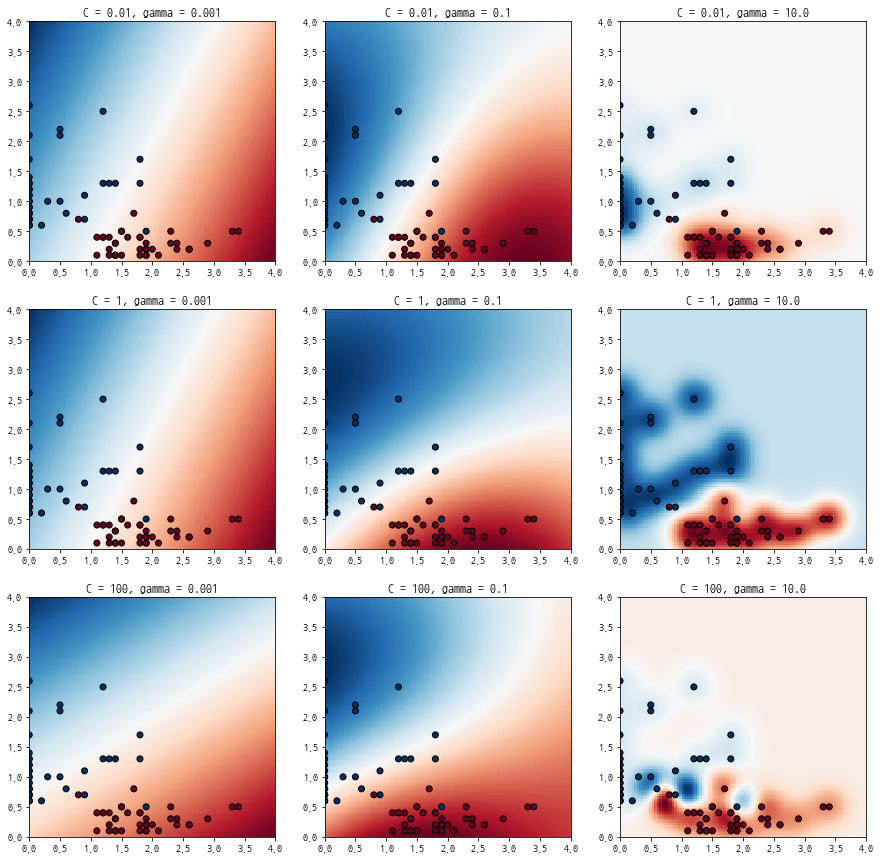

In [35]:
plt.figure(figsize=(15,15))

for i, (C, gamma, clf) in enumerate(classifiers):
    #print(i, (C, gamma, clf))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.subplot(len(C_canditates), len(gamma_canditates), i + 1)
    plt.title('C = {}, gamma = {}'.format(C, gamma))
    
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
        
    plt.scatter(x=X['3P'], y=X['BLK'], 
                c=position, cmap=plt.cm.RdBu_r, edgecolors='k')

plt.show()
    
# enumerate() : 인수로 지정된 리스트를 인덱스와 값 형태의 튜플로 리턴함
# decision_function() : 사이킷런 패키지의 Classification 클래스는 판별 함수값을 계산함
# subplot 그래프(다단 그래프) : 두 개 이상의 그래프의 상관 관계를 효과적으로 표시할 수 있음
# pcolormesh() : cmap으로 지정한 색상을 이용해 xx, yy로 지정된 단계로 Z에 저장된 결정 경계면을 표시함
    

9개의 차트 중 가운데 차트가 GridSearch를 통해 얻은 C와 gamma를 사용해 학습한 SVM 모델이며 균등하게 두 그룹이 분류된 것을 확인할 수 있다. (예. C=1, gamma=0.1)

결과 차트를 좌에서 우로 보면 감마의 크기에 따른 결정 경계의 곡률 변화를 확인할 수 있고 위에서 아래로 보면 C의 크기에 따른 결정 경계의 위치 변화를 확인할 수 있다.

### 5. 모델 테스트 

In [37]:
X_test = test[['3P', 'BLK']]
Y_test = test[['Pos']]

최적의 파라미터로 학습된 모델을 저장함

성능 평가

In [41]:
y_true, y_pred = Y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
# print('정확도 : {}'.format(accuracy_score(y_true, y_pred)))

# 사이킷런 metrics 패키지에서는 정밀도, 재현율, F1 Score를 계산하는 classification_report() 메소드를 제공함
# 이 메소드는 정밀도, 재현율, F1 Score를 각각 계산하고 그 평균값으로 전체 모형의 성능을 평가함
# accuracy(정확도) : 예측이 얼마나 정답과 정확한가
#   -> 전체 학습데이터의 개수에서 각 클래스에서 자신의 클래스를 정확하게 맞춘 개수의 비율
# precision(정밀도) : 예측한 것 중에서 정답의 비율
# recall(재현율) : 찾아야 할 것 중에서 실제로 찾은 비율
# f1-score : 정밀도와 재현율의 조화 평균으로 f1-score 값이 높으면 성능이 높다고 할 수 있음
# macro : 단순 평균
# weighted : 각 클래스에 속하는 표본의 갯수로 가중 평균


              precision    recall  f1-score   support

           C       0.86      0.86      0.86         7
          SG       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20

정확도 : 0.9
